# Chapter 3 - Classification on MNIST

## Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

In [2]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= '0.20' 

In [3]:
# Common imports
import numpy as np
import os

In [4]:
# To make this notebook's output stable across runs
np.random.seed(42)

In [5]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [6]:
# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

In [7]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## MNIST

In [8]:
from sklearn.datasets import fetch_openml

In [9]:
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [10]:
X, y = mnist['data'], mnist['target']

In [11]:
X.shape

(70000, 784)

In [12]:
y.shape

(70000,)

In [13]:
28 * 28

784

### Example

Saving figure some_digit_plot


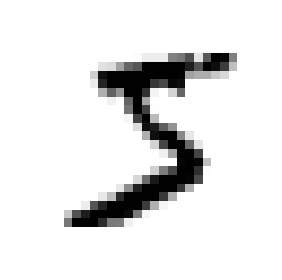

In [14]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary)
plt.axis('off')

save_fig('some_digit_plot')
plt.show()

In [15]:
y[0]

'5'

### Convert string to number

In [16]:
y = y.astype(np.uint8)

### Plot digits

In [17]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, 
               cmap=mpl.cm.binary,
               interpolation='nearest')
    plt.axis('off')

In [18]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure more_digits_plot


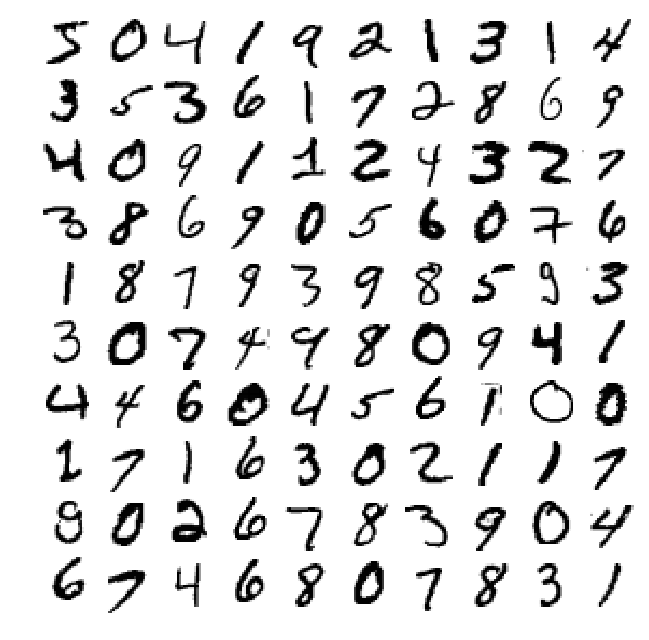

In [19]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
save_fig("more_digits_plot")
plt.show()

### train/test split

In [20]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Two classes: 5 and not-5

In [21]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

**Note:** some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

### SGD Classifier

In [22]:
from sklearn.linear_model import SGDClassifier

In [23]:
sgd_clf = SGDClassifier(max_iter=1000,
                        tol=1e-3,
                        random_state=42)

sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

Now we can use it to detect images of the number 5:

In [24]:
sgd_clf.predict([some_digit])

array([ True])

### Performance Measures

### 1 - Cross-Validation

In [27]:
from sklearn.model_selection import cross_val_score

In [28]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [29]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

In [30]:
skfolds = StratifiedKFold(n_splits=3, random_state=42)

/Users/dongdongdongdong/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:297: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [33]:
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    
    print('Asscuray:', n_correct / len(y_pred))

Asscuray: 0.95035
Asscuray: 0.96035
Asscuray: 0.9604


In [34]:
from sklearn.base import BaseEstimator

In [37]:
class Never5Classifier(BaseEstimator):
    
    def fit(self, X, y=None):
        pass
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [40]:
never_5_clf = Never5Classifier()

In [41]:
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

### 2 - Confusion Matrix

In [42]:
from sklearn.model_selection import cross_val_predict

In [43]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [44]:
from sklearn.metrics import confusion_matrix

In [45]:
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

A perfect classifier would have only true positive and true negative:

In [46]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall：

In [47]:
from sklearn.metrics import precision_score, recall_score

In [48]:
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [49]:
3530 / (3530 + 687)

0.8370879772350012

In [50]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [51]:
3530 / (1891 + 3530)

0.6511713705958311

### F1 Score:

In [52]:
from sklearn.metrics import f1_score

In [53]:
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [54]:
3530 / (3530 + (687 + 1891) / 2)

0.7325171197343847

### Precision/Recall Trade-off:

In [55]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [56]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([ True])

In [57]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)

y_some_digit_pred

array([False])

In [58]:
y_scores = cross_val_predict(sgd_clf, 
                             X_train, y_train_5, 
                             cv=3, 
                             method='decision_function')

Use the `precision_recall_curve()` function to compute precision and recall for all possible thresholds:

In [59]:
from sklearn.metrics import precision_recall_curve

In [60]:
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


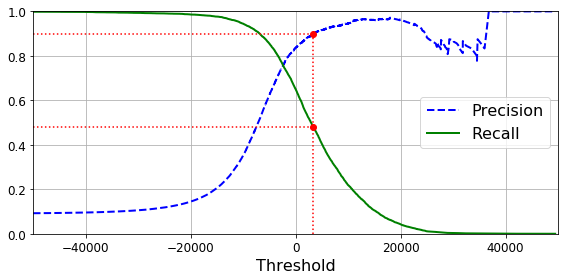

In [61]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown



recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

### Plot Precision versus Recall:

Saving figure precision_vs_recall_plot


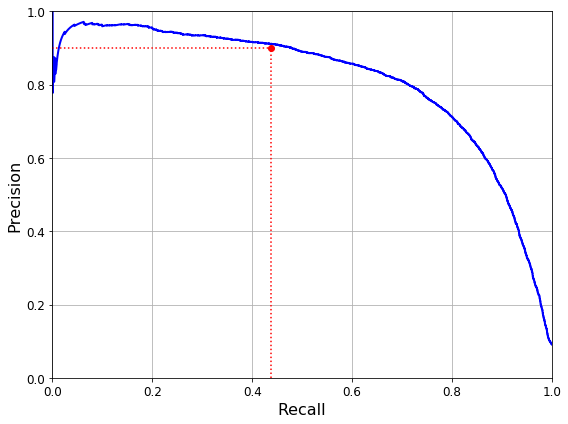

In [62]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()

In [63]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [64]:
threshold_90_precision

3370.0194991439594

In [65]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [66]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [67]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

In [68]:
from sklearn.metrics import roc_curve

In [69]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


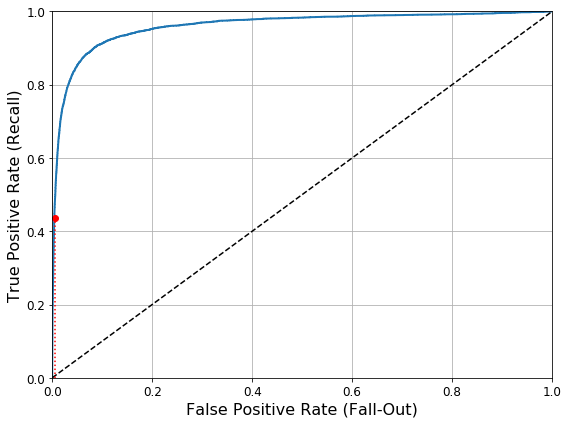

In [70]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

### Compute ROC AUC:

In [71]:
from sklearn.metrics import roc_auc_score

In [72]:
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [73]:
from sklearn.ensemble import RandomForestClassifier

In [74]:
forest_clf = RandomForestClassifier(n_estimators=100,
                                    random_state=42)

y_probas_forest = cross_val_predict(forest_clf,
                                    X_train, y_train_5,
                                    cv=3,
                                    method='predict_proba')

In [75]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

Saving figure roc_curve_comparison_plot


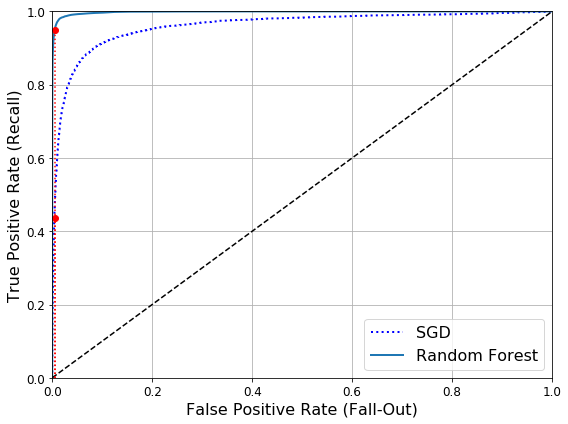

In [76]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [77]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [78]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [79]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## Multiclass Classification

### Support Vector Machine Classifier:

In [80]:
from sklearn.svm import SVC

In [81]:
svm_clf = SVC()

In [82]:
svm_clf.fit(X_train, y_train)

SVC()

In [83]:
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [84]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [85]:
np.argmax(some_digit_scores)

5

In [86]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [87]:
svm_clf.classes_[5]

5

### One VS Rest:

In [88]:
from sklearn.multiclass import OneVsRestClassifier

In [89]:
ovr_clf = OneVsRestClassifier(SVC(gamma='auto', random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])

OneVsRestClassifier(estimator=SVC(gamma='auto', random_state=42))

In [90]:
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

## Error Analysis

In [91]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.8983, 0.891 , 0.9018])

In [92]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

In [93]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

Saving figure confusion_matrix_plot


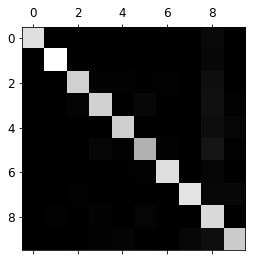

In [94]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_plot", tight_layout=False)
plt.show()

In [95]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Saving figure confusion_matrix_errors_plot


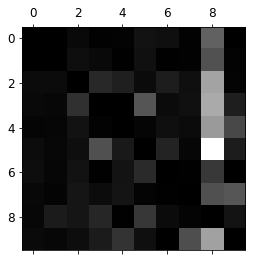

In [96]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
save_fig("confusion_matrix_errors_plot", tight_layout=False)
plt.show()

### Plot examples of Digit 3 and Digit 5:

In [97]:
cl_a, cl_b = 3, 5

Saving figure error_analysis_digits_plot


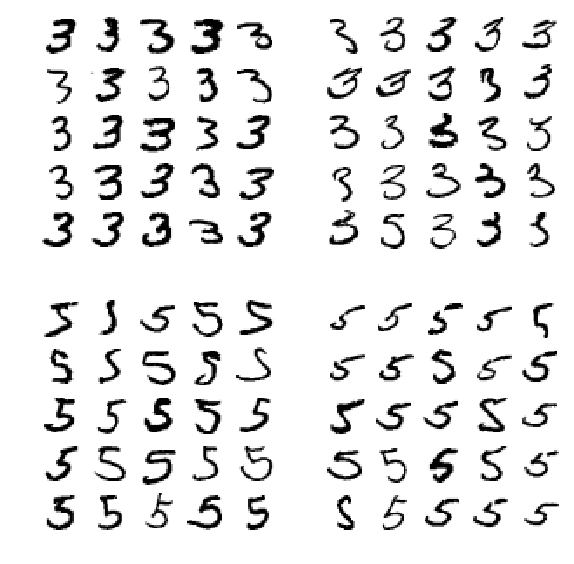

In [98]:
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
save_fig("error_analysis_digits_plot")

plt.show()

## Muti-label Classification

In [99]:
from sklearn.neighbors import KNeighborsClassifier

In [100]:
y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)

y_multilabel = np.c_[y_train_large, y_train_odd]
y_multilabel[:5]

array([[False,  True],
       [False, False],
       [False, False],
       [False,  True],
       [ True,  True]])

## Multi-output Classification

Let's build a system that removes noise from images.

In [101]:
noise = np.random.randint(0, 100, (len(X_train), 784))

In [102]:
X_train_mod = X_train + noise

In [103]:
noise = np.random.randint(0, 100, (len(X_test), 784))

In [104]:
X_test_mod = X_test + noise

In [105]:
y_train_mod = X_train
y_test_mod = X_test

Saving figure noisy_digit_example_plot


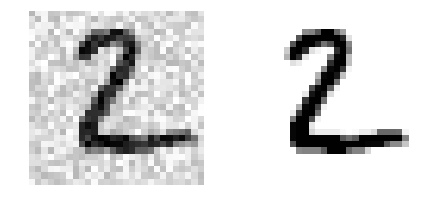

In [107]:
some_index = 1

plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
save_fig('noisy_digit_example_plot')

plt.show()

Now let's train the classifier and make it clean this image:

In [109]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

Saving figure cleaned_digit_example_plot


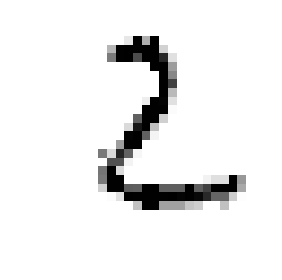

In [110]:
clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)
save_fig('cleaned_digit_example_plot')